## Support Vector Machines Classifier 

This notebook contains the SVN classifier on the collected data.

Table of Content:
* **1. Import required packages**
* **2. Import files**
* **3. Undersampling the majority class**
* **4. Word Frequency**
* 4.1 Bag of Words
* 4.2 TF-IDF
* **5. Support Vector Machines**
* 5.1 Define the target and explanatory variable, cross validation
* 5.2 Build the model with Sklearn pipeline
* 5.3 Evaluation of the model 
* *5.3.1 Modell Accuracy*
* *5.3.2 Confusion Matrix*
* *5.3.3 ROC curve*

### 1. Import required packages

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

### 2. Import files

In [2]:
abt_covid = pd.read_pickle('C:/Users/molna/Desktop/Szakdolgozat/adatok/abt_covid_featured.pkl')

print("ABT table has {} rows and {} columns".format(len(abt_covid), len(abt_covid.columns)))

ABT table has 63633 rows and 50 columns


In [4]:
# select only the relevant features for the modelling
data = abt_covid[["dezinf", "title_lemmas", "text_lemmas"]]

### 3. Undersampling the majority class

In [5]:
class_count_0, class_count_1 = data['dezinf'].value_counts()

In [6]:
class_0 = data[data['dezinf'] == 0]
class_1 = data[data['dezinf'] == 1]
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (50358, 3)
class 1: (13275, 3)


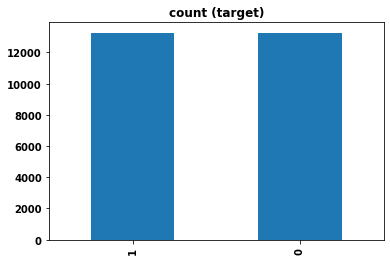

In [7]:
class_0_under = class_0.sample(class_count_1)

data_under = pd.concat([class_0_under, class_1], axis=0)

data_under['dezinf'].value_counts().plot(kind='bar', title='count (target)')

### 4. Word Frequency

In [8]:
def dummy(doc):
    return doc

#### 4.1 Bag of Words

In [9]:
count_vect = CountVectorizer(tokenizer=dummy, preprocessor=dummy,)

In [10]:
word_count_matrix = count_vect.fit_transform(data_under["text_lemmas"])

In [11]:
word_count_matrix

<26550x192269 sparse matrix of type '<class 'numpy.int64'>'
	with 3960272 stored elements in Compressed Sparse Row format>

#### 4.2 TF-IDF
(i.e Term Frequency times inverse document frequency)

In [12]:
tf_idf = TfidfTransformer()
tf_idf.fit(word_count_matrix)
tf_idf.idf_

array([ 9.80052833,  6.72091457,  8.8842376 , ..., 10.49367551,
       10.49367551, 10.49367551])

In [13]:
idf = pd.DataFrame(tf_idf.idf_, index=count_vect.get_feature_names(), columns=['idf_weight'])
idf.sort_values(by='idf_weight')

,idf_weight
koronavírus,1.289806
járvány,1.507104
ember,1.891314
tud,1.927597
ország,2.056933
...,...
novikov,10.493676
fülöppel,10.493676
noviemb,10.493676
novomatic,10.493676


### 5.  Support Vector Machines (SVN)

#### 5.1 Define the target and explanatory variable, cross validation

In [14]:
X = data_under['text_lemmas']
y = data_under['dezinf']

In [15]:
# split data into 80% training and 20% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 5.2 Build the model with Sklearn pipeline

In [16]:
svm_pipe = Pipeline([('vector', CountVectorizer(tokenizer=dummy,
                                                preprocessor=dummy)),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', 
                                                   #penalty='12',
                                                   alpha=1e-3,
                                                   #n_iter=5,
                                                   random_state=42))
                        ])

In [17]:
svm_model = svm_pipe.fit(X_train, y_train)

#### 5.3 Evaluation of the model

#### 5.3.1 Modell Accuracy

In [19]:
predicted = svm_model.predict(X_test)

score = round(svm_model.score(X_test, y_test), 2)

print("The Accuracy of the naive bayes model on the article text is: {} % with the balanced dataset".format(score))

The Accuracy of the naive bayes model on the article text is: 0.83 % with the balanced dataset


#### 5.3.2 Confusion Matrix

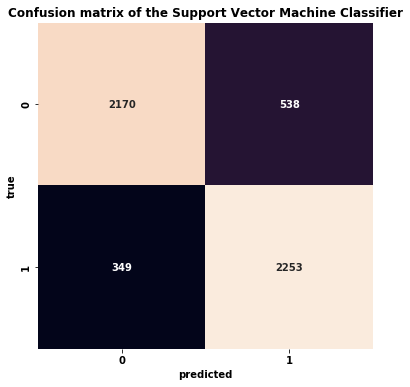

Failure first row (%):  24.79 %
Failure second row (%):  15.49 %


In [22]:
cm = confusion_matrix(y_test, predicted)
plt.figure(figsize = (6,6))
sns.heatmap(cm, annot=True, cbar=False, fmt="g")
plt.title('Confusion matrix of the Support Vector Machine Classifier')
plt.xlabel("predicted")
plt.ylabel("true")

plt.show()

print("Failure first row (%): ", round(confusion_matrix(y_test, predicted)[0,1]/confusion_matrix(y_test, predicted)[0,0]*100,2),"%")
print("Failure second row (%): ", round(confusion_matrix(y_test, predicted)[1,0]/confusion_matrix(y_test, predicted)[1,1]*100,2),"%")

#### 5.3.3 ROC curve

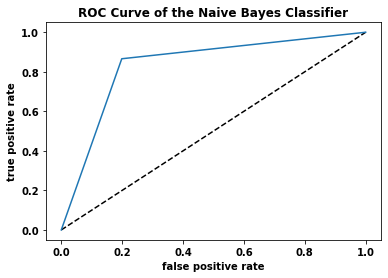

The AUC score of the Naive Bayes Classifier: 0.83


In [23]:
fpr, tpr, thresholds = roc_curve(y_test, predicted)

# plot the diagonal line
plt.plot([0,1],[0,1],'k--') 
# plot the ROC curve
plt.plot(fpr, tpr, label='NB') 
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC Curve of the Naive Bayes Classifier')
plt.show()

print("The AUC score of the Naive Bayes Classifier: {}".format(round(roc_auc_score(y_test, predicted), 2)))

In [25]:
prediction = svm_model.predict(data_under['text_lemmas'])

In [26]:
data_under["prediction"] = prediction

In [27]:
data_under.head()

,dezinf,title_lemmas,text_lemmas,prediction
"""20342""",0,"[online, piactér, menthet, magyar, vállalkozás]","[pandémia, kkv, k, harmad, növel, eladás, onli...",0
"""14169""",0,"[polgárőr, segít, járvány, idő]","[polgárőr, segít, koronavírus, járvány, idő, n...",0
"""275""",0,"[év, ezelőtt, kiderül, brit, tud, megbirkózik,...","[komoly, nyomás, került, brit, kormány, utóbbi...",0
"""47365""",0,"[védőoltás, mellékhatás, szlovákia, eset, vizs...","[szlovákia, koronavírus, oltás, kapcsolat, ápr...",1
"""27221""",0,"[olaszország, meghosszabbít, vészhelyzet]","[megszavaz, koronavírus, járvány, elrendelt, v...",0
